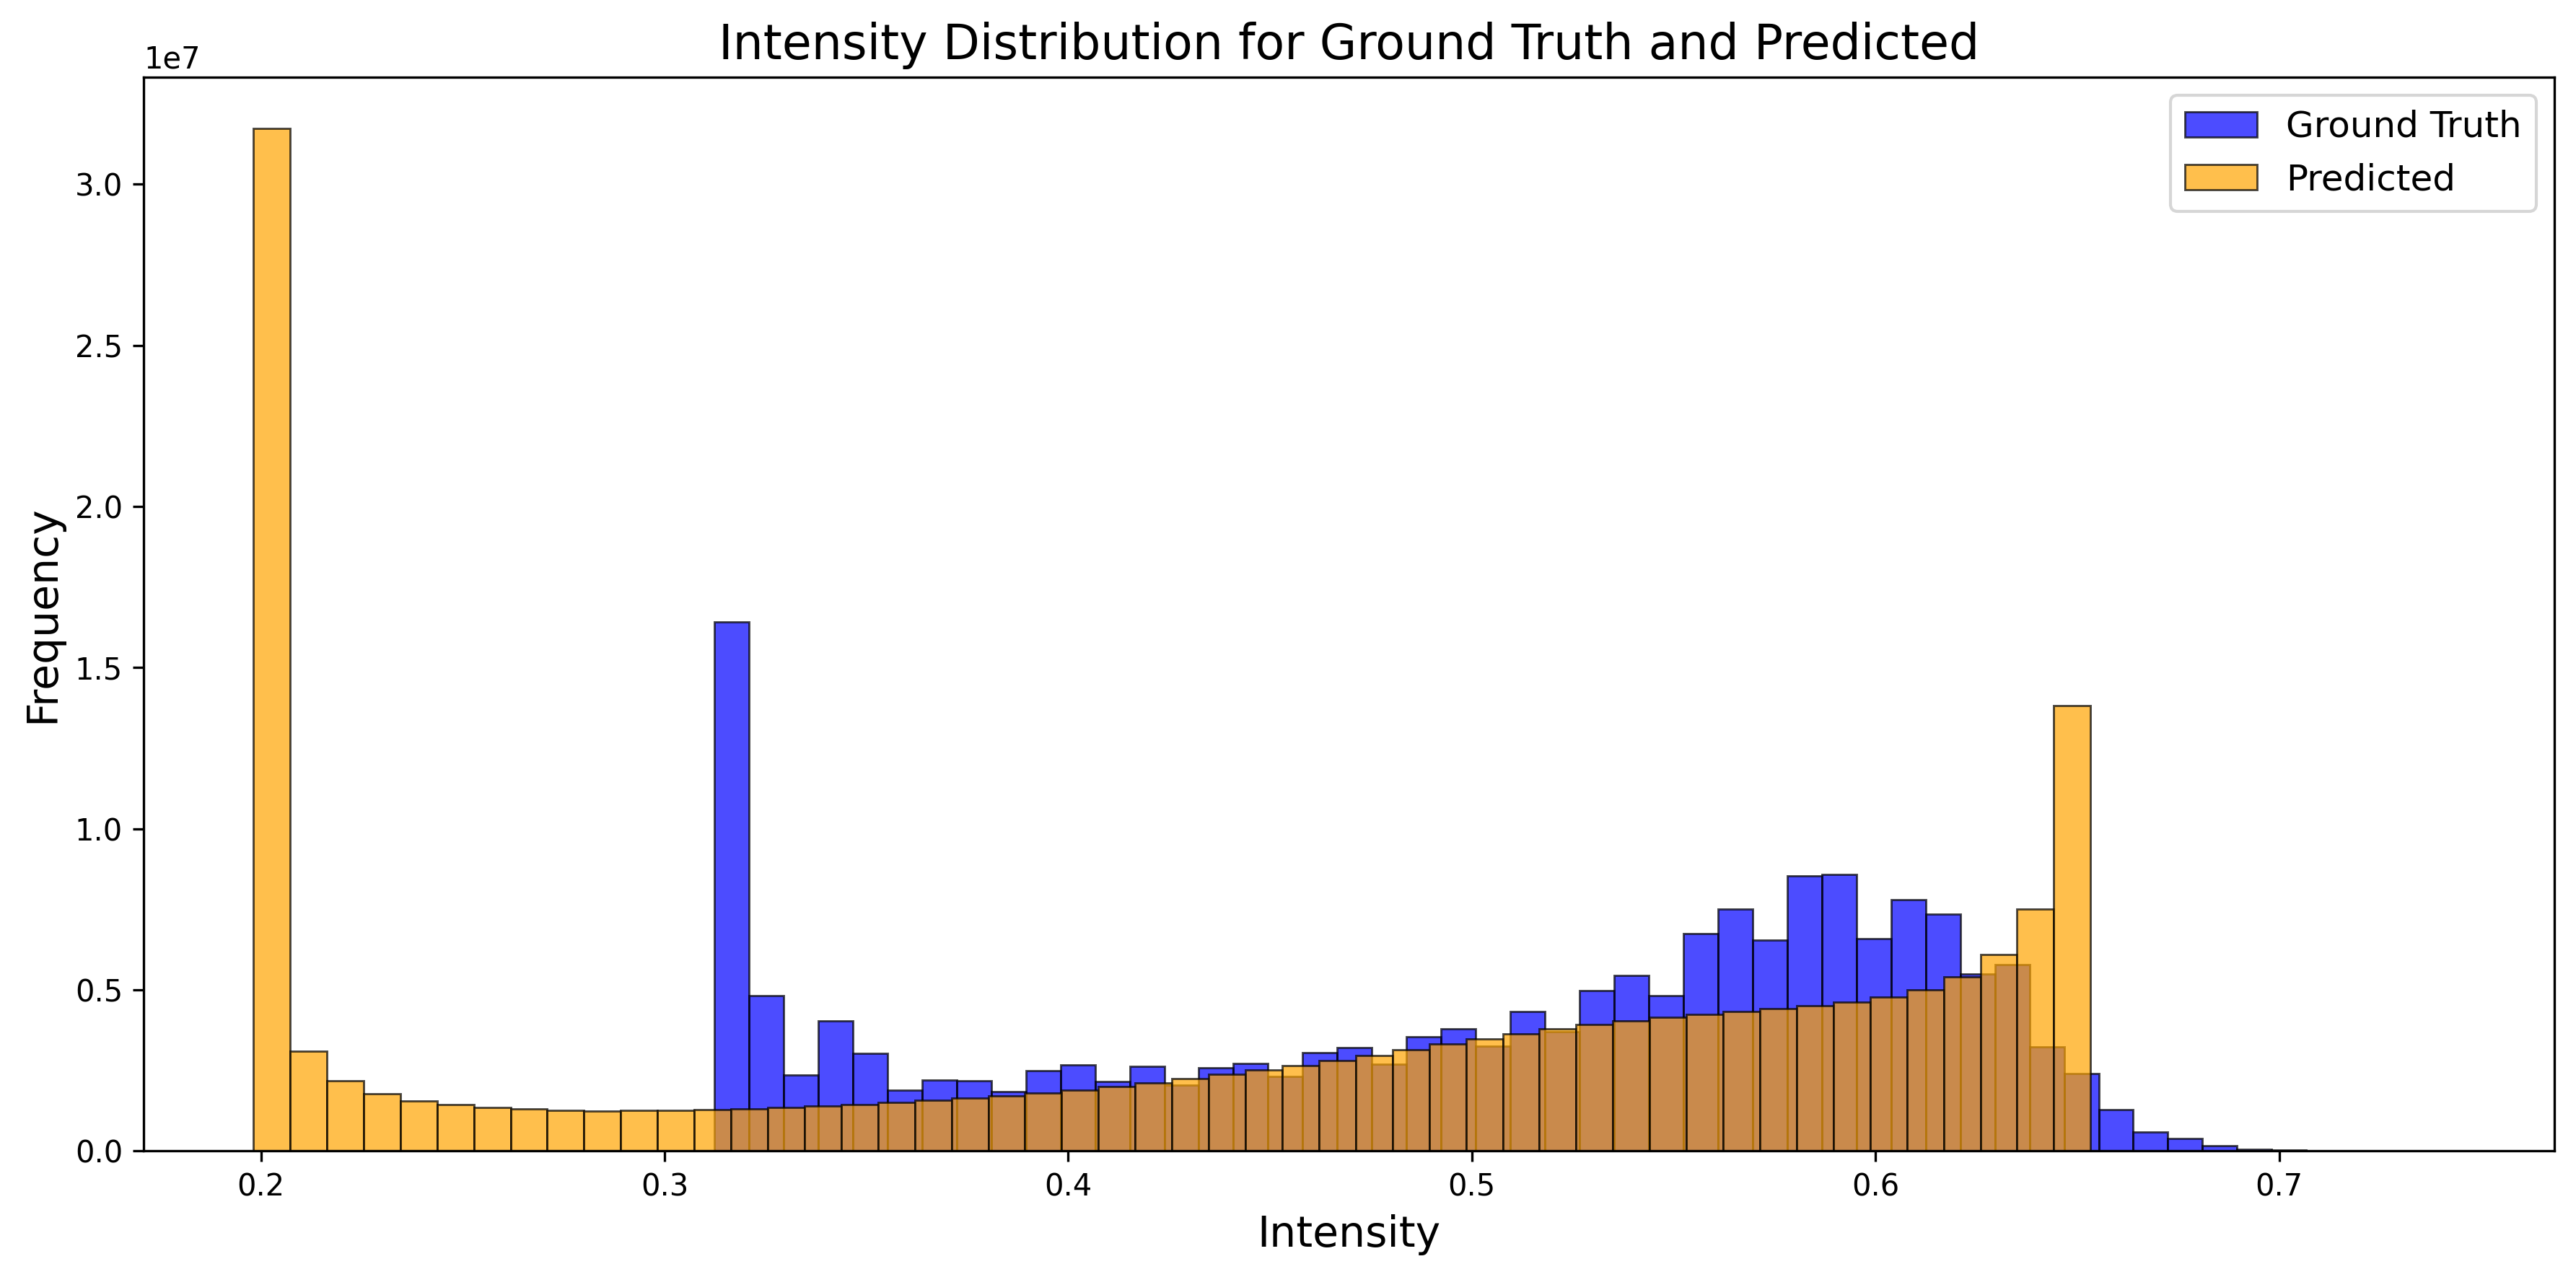

In [1]:

import os
import torch
from PIL import Image
from generator import Generator
from generator_pix2pix import Generator as Generator_pix2pix
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transform_utils import lidar_transform, intensity_real_transform, incidence_transform, binary_transform, reflectance_transform

"""
This script loads a pre-trained deep learning model and compares the distribution of ground truth and predicted intensity values for a given test set. 

Functions:
    load_model(folder, in_channel, input_channel_config):
        Loads a pre-trained model from the specified folder with the given input and output channels.

    get_intensities(model, filename, input_channel_config):
        Generates the ground truth and predicted intensity values for a given image file using the specified model.
        
"""

def load_model(folder, in_channel, input_channel_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Generator(img_channels=in_channel, out_channels=1)
    Checkpoint_path = f'/DATA2/Vivek/Code/Implementation/Objective 3/CycleGAN/Output_4.0/gen_r.pth.tar_T1'

    checkpoint = torch.load(Checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()

    return model

def get_intensities(model, filename, input_channel_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    paths = {img_type: os.path.join(base_path, subfolder, filename) for img_type, subfolder in zip(subfolders, subfolders)}

    # Load the images using the updated paths
    lidar = lidar_transform(Image.open(paths['test_lidar_depth']).convert("L"))
    intensity = intensity_real_transform(Image.open(paths['test_lidar_intensity']).convert("L"))
    incidence = incidence_transform(Image.open(paths['test_incidence_mask']).convert("L"))
    binary = binary_transform(Image.open(paths['test_binary_mask']).convert("L"))
    reflectance = reflectance_transform(Image.open(paths['test_lidar_reflectance']).convert("L"))

    intensity_target = intensity.unsqueeze(0).to(device)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor


    if input_channel_config == "T1":
        input_data = torch.cat((lidar, incidence, reflectance), dim=0)  # T1 #in_channels=3
    else:
        raise ValueError("Invalid input_channel_config")

    input_data = input_data.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_data)

    intensity_target = inverse_transform(intensity_target)
    output = inverse_transform(output)

    intensity_target_np = intensity_target.squeeze().cpu().detach().numpy().flatten()
    output_np = output.squeeze().cpu().detach().numpy().flatten()
    
    return intensity_target_np, output_np

# Define base paths for input images
base_path = r"/DATA2/Vivek/Data/Trial_3/Test/"
subfolders = ['test_lidar_depth', 'test_lidar_rgb', 'test_color_mask', 'test_incidence_mask', 'test_binary_mask', 'test_lidar_intensity', 'test_lidar_label','test_lidar_reflectance']

# Define the model folder, in_channels, and input_channel_config
folder = "T1"
in_channel = 3
input_channel_config = folder

# Load the model
model = load_model(folder, in_channel, input_channel_config)

intensities_gt = []
intensities_pred = []

for filename in os.listdir(os.path.join(base_path, subfolders[0])):
    if filename.endswith('.jpg'):
        gt_intensities, pred_intensities = get_intensities(model, filename, input_channel_config)
        
        intensities_gt.extend(gt_intensities)
        intensities_pred.extend(pred_intensities)

# Create histograms of the intensities
plt.figure(figsize=(12, 6), dpi=300)

# Histogram for ground truth intensities
plt.hist(intensities_gt, bins=50, alpha=0.7, color='blue', edgecolor='black', linewidth=0.7, label="Ground Truth")
# Histogram for predicted intensities
plt.hist(intensities_pred, bins=50, alpha=0.7, color='orange', edgecolor='black', linewidth=0.7, label="Predicted")

plt.xlabel('Intensity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Intensity Distribution for Ground Truth and Predicted', fontsize=16)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()
